# **Extracting Information from Legal Documents Using RAG**

## **Objective**

The main objective of this assignment is to process and analyse a collection text files containing legal agreements (e.g., NDAs) to prepare them for implementing a **Retrieval-Augmented Generation (RAG)** system. This involves:

* Understand the Cleaned Data : Gain a comprehensive understanding of the structure, content, and context of the cleaned dataset.
* Perform Exploratory Analysis : Conduct bivariate and multivariate analyses to uncover relationships and trends within the cleaned data.
* Create Visualisations : Develop meaningful visualisations to support the analysis and make findings interpretable.
* Derive Insights and Conclusions : Extract valuable insights from the cleaned data and provide clear, actionable conclusions.
* Document the Process : Provide a detailed description of the data, its attributes, and the steps taken during the analysis for reproducibility and clarity.

The ultimate goal is to transform the raw text data into a clean, structured, and analysable format that can be effectively used to build and train a RAG system for tasks like information retrieval, question-answering, and knowledge extraction related to legal agreements.

### **Business Value**  


The project aims to leverage RAG to enhance legal document processing for businesses, law firms, and regulatory bodies. The key business objectives include:

* Faster Legal Research: <br> Reduce the time lawyers and compliance officers spend searching for relevant case laws, precedents, statutes, or contract clauses.
* Improved Contract Analysis: <br> Automatically extract key terms, obligations, and risks from lengthy contracts.
* Regulatory Compliance Monitoring: <br> Help businesses stay updated with legal and regulatory changes by retrieving relevant legal updates.
* Enhanced Decision-Making: <br> Provide accurate and context-aware legal insights to assist in risk assessment and legal strategy.


**Use Cases**
* Legal Chatbots
* Contract Review Automation
* Tracking Regulatory Changes and Compliance Monitoring
* Case Law Analysis of past judgments
* Due Diligence & Risk Assessment

## **1. Data Loading, Preparation and Analysis** <font color=red> [20 marks] </font><br>

### **1.1 Data Understanding**

The dataset contains legal documents and contracts collected from various sources. The documents are present as text files (`.txt`) in the *corpus* folder.

There are four types of documents in the *courpus* folder, divided into four subfolders.
- `contractnli`: contains various non-disclosure and confidentiality agreements
- `cuad`: contains contracts with annotated legal clauses
- `maud`: contains various merger/acquisition contracts and agreements
- `privacy_qa`: a question-answering dataset containing privacy policies

The dataset also contains evaluation files in JSON format in the *benchmark* folder. The files contain the questions and their answers, along with sources. For each of the above four folders, there is a `json` file: `contractnli.json`, `cuad.json`, `maud.json` `privacy_qa.json`. The file structure is as follows:

```
{
    "tests": [
        {
            "query": <question1>,
            "snippets": [{
                    "file_path": <source_file1>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 1>
                },
                {
                    "file_path": <source_file2>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 2>
                }, ....
            ]
        },
        {
            "query": <question2>,
            "snippets": [{<answer context for que 2>}]
        },
        ... <more queries>
    ]
}
```

### **1.2 Load and Preprocess the data** <font color=red> [5 marks] </font><br>

#### Loading libraries

In [4]:
## The following libraries might be useful
# !pip install -q langchain-openai
# !pip install -U -q langchain-community
# !pip install -U -q langchain-chroma
# !pip install -U -q datasets
# !pip install -U -q ragas
# !pip install -U -q rouge_score

In [5]:
# Import essential libraries
import os
import pandas as pd 
from pathlib import Path

import random
import json

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import nltk
from nltk.corpus import stopwords
from collections import Counter
import re

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.docstore.document import Document
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI


from tqdm import tqdm

# for evaluation

from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from ragas.metrics import answer_relevancy, context_precision, context_recall, ContextRelevance, faithfulness, ResponseGroundedness
from ragas import evaluate as ragas_evaluate
from langchain.schema.runnable import RunnableLambda
from datasets import Dataset

#### **1.2.1** <font color=red> [3 marks] </font>
Load all `.txt` files from the folders.

You can utilise document loaders from the options provided by the LangChain community.

Optionally, you can also read the files manually, while ensuring proper handling of encoding issues (e.g., utf-8, latin1). In such case, also store the file content along with metadata (e.g., file name, directory path) for traceability.

In [6]:
# Load the files as documents
corpus_path = Path(r".\rag_legal\corpus")
benchmark_path = Path(r".\rag_legal\benchmarks")


documents = []

for txt_file in corpus_path.rglob("*txt"):

    if txt_file.stat().st_size == 0:
        print(f"skipping empty file {txt_file}")

    try: 
        content = txt_file.read_text(encoding="utf-8")
    except UnicodeDecodeError:
        content = txt_file.read_text(encoding="Latin1")

    if not content.strip():
        print(f"skipping empty content {txt_file}")
        continue

    #fetch the Meta Data information

    document_type = txt_file.parent.name
    filename = txt_file.name
    word_count = len(content.split())
    file_size = txt_file.stat().st_size

    # Append them to list
    documents.append({
        "document_type": document_type,
        "filename": filename,
        "content": content,
        "word_count": word_count,
        "file_size_bytes": file_size
    })

df = pd.DataFrame(documents)

In [7]:
df.head()

document_type                                           filename  \
0   contractnli  01_Bosch-Automotive-Service-Solutions-Mutual-N...   
1   contractnli                     12032018_NDA_The_20Munt_EN.txt   
2   contractnli  5-NSK-Confidentiality-Agreement-for-Suppliers.txt   
3   contractnli              ADVANIDE-NON-DISCLOSURE-AGREEMENT.txt   
4   contractnli               AfriGIS_Client-NDA_Template_2019.txt   

                                             content  word_count  \
0  MUTUAL NON-DISCLOSURE AGREEMENT\nBetween\nAND\...        2313   
1  Confidentiality Agreement\nThis Confidentialit...        1128   
2  NON-DISCLOSURE AGREEMENT\nThis Agreement is ef...        1897   
3  NON-DISCLOSURE AGREEMENT\nR 2019/01\n(Pls. fil...         984   
4  CONFIDENTIALITY AND NON-DISCLOSURE AGREEMENT\n...        3582   

   file_size_bytes  
0            15363  
1             6933  
2            12526  
3             6201  
4            24308

#### **1.2.2** <font color=red> [2 marks] </font>
Preprocess the text data to remove noise and prepare it for analysis.

Remove special characters, extra whitespace, and irrelevant content such as email and telephone contact info.
Normalise text (e.g., convert to lowercase, remove stop words).
Handle missing or corrupted data by logging errors and skipping problematic files.

In [8]:
# Clean and preprocess the data
nltk.download('stopwords')

def clean_text(text: str, remove_stopwords=True) -> str:
    try: 
        # Change the content to lower case
        text = text.lower()

        # remove email by REGX
        text = re.sub(r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}","",text)

        # remove phone number
        text = re.sub(r"\+?\d[\d\s\-]{8,}\d","",text)

        # Remove special characters like symbols, punchtuations, etc
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)

        # Remove extra spaces 
        text = re.sub(r"\s+"," ",text).strip()

        if remove_stopwords:
            stop_words = set(stopwords.words("english"))
            words = text.split()
            words = [word for word in words if word not in stop_words]
            text = " ".join(words)

        return text
    
    except Exception as e:
        print(f"[Error cleaning text]{e}")
        return ""

df["cleaned_content"] = df["content"].apply(lambda x: clean_text(x, remove_stopwords=False))

df[["filename","document_type","word_count","cleaned_content"]].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vinay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


filename document_type  \
0  01_Bosch-Automotive-Service-Solutions-Mutual-N...   contractnli   
1                     12032018_NDA_The_20Munt_EN.txt   contractnli   
2  5-NSK-Confidentiality-Agreement-for-Suppliers.txt   contractnli   
3              ADVANIDE-NON-DISCLOSURE-AGREEMENT.txt   contractnli   
4               AfriGIS_Client-NDA_Template_2019.txt   contractnli   

   word_count                                    cleaned_content  
0        2313  mutual nondisclosure agreement between and sub...  
1        1128  confidentiality agreement this confidentiality...  
2        1897  nondisclosure agreement this agreement is effe...  
3         984  nondisclosure agreement r 201901 pls fill in t...  
4        3582  confidentiality and nondisclosure agreement be...

### **1.3 Exploratory Data Analysis** <font color=red> [10 marks] </font><br>

#### **1.3.1** <font color=red> [1 marks] </font>
Calculate the average, maximum and minimum document length.

In [9]:
# Calculate the average, maximum and minimum document length.
df["word_count"] = df["cleaned_content"].apply(lambda x: len(x.split()))

average_length = df["word_count"].mean()
max_length = df["word_count"].max()
min_length = df["word_count"].min()

print(f"Average length: {average_length}")
print(f"Max length: {max_length}")
print(f"Min length: {min_length}")


Average length: 16055.080691642652
Max length: 155964
Min length: 217


#### **1.3.2** <font color=red> [4 marks] </font>
Analyse the frequency of occurrence of words and find the most and least occurring words.

Find the 20 most common and least common words in the text. Ignore stop words such as articles and prepositions.

In [10]:
# Find frequency of occurence of words

stop_words = set(stopwords.words("english"))
all_words = " ".join(df["cleaned_content"]).split()
filtered_words = [word for word in all_words if word not in stop_words]

word_freq = Counter(filtered_words)
most_common_20 = word_freq.most_common(20)
least_common_20 = word_freq.most_common()[:-21:-1]

print(f"Most Common 20 Words: \n {most_common_20}")
print(f"Least Common 20 Words: \n {least_common_20}")


Most Common 20 Words: 
 [('company', 148135), ('shall', 107719), ('agreement', 104309), ('section', 75150), ('parent', 58009), ('party', 49378), ('date', 39236), ('time', 35187), ('material', 34190), ('merger', 33840), ('subsidiaries', 33315), ('applicable', 31311), ('including', 29214), ('respect', 28804), ('may', 27992), ('stock', 26647), ('information', 25589), ('parties', 24502), ('b', 23877), ('business', 23443)]
Least Common 20 Words: 
 [('collins', 1), ('newer', 1), ('peoplefuncom', 1), ('nonmarketing', 1), ('httpwwwyouronlinechoiceseu', 1), ('httpwwwaboutadsinfochoices', 1), ('checkins', 1), ('httpsvunglecomprivacypolicy', 1), ('vungle', 1), ('httpswwwtapresearchcomuserprivacy', 1), ('tapresearch', 1), ('httpsdevtapjoycomfaqtapjoyprivacypolicy', 1), ('tapjoy', 1), ('httpswwwstartappcompolicyprivacypolicy', 1), ('startappcom', 1), ('httpaboutsoomlaenduserprivacypolicy', 1), ('soomla', 1), ('httpswwwsmaatocomprivacy', 1), ('smaato', 1), ('httpspinsightmediacomprivacy', 1)]


#### **1.3.3** <font color=red> [4 marks] </font>
Analyse the similarity of different documents to each other based on TF-IDF vectors.

Transform some documents to TF-IDF vectors and calculate their similarity matrix using a suitable distance function. If contracts contain duplicate or highly similar clauses, similarity calculation can help detect them.

Identify for the first 10 documents and then for 10 random documents. What do you observe?

In [11]:
# Transform the page contents of documents

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df["cleaned_content"])

# Compute similarity scores
similarity_matrix = cosine_similarity(tfidf_matrix)

In [12]:
tfidf_matrix

similarity_matrix

array([[1.        , 0.54977432, 0.87437905, ..., 0.33388997, 0.27288566,
        0.34705562],
       [0.54977432, 1.        , 0.56020864, ..., 0.24248096, 0.20869641,
        0.25080003],
       [0.87437905, 0.56020864, 1.        , ..., 0.32098279, 0.26599988,
        0.33666361],
       ...,
       [0.33388997, 0.24248096, 0.32098279, ..., 1.        , 0.674427  ,
        0.73985796],
       [0.27288566, 0.20869641, 0.26599988, ..., 0.674427  , 1.        ,
        0.78158834],
       [0.34705562, 0.25080003, 0.33666361, ..., 0.73985796, 0.78158834,
        1.        ]], shape=(694, 694))

In [13]:
# create a list of 10 random integers
random.seed(42)
random_indices = random.sample(range(len(df)),10)
print(random_indices)


[654, 114, 25, 281, 250, 228, 142, 104, 692, 558]


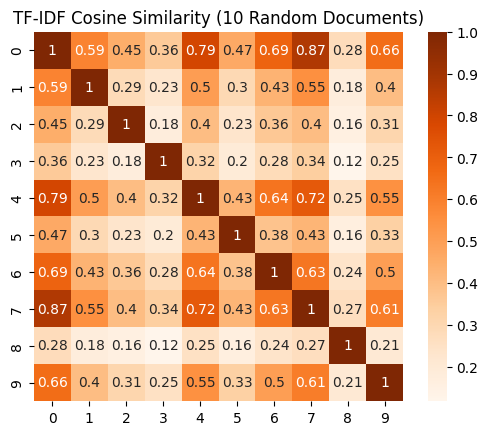

In [14]:
# Compute similarity scores for 10 random documents

random_10_sim = similarity_matrix[random_indices][:, random_indices]

plt.Figure(figsize=(10,6))
sns.heatmap(random_10_sim, annot=True, cmap="Oranges", square=True)
plt.title("TF-IDF Cosine Similarity (10 Random Documents)")
plt.show()


As you can see 
Doc 0 vs Doc 7: 0.87 
Doc 0 vs Doc 4: 0.79
Doc 4 vs Doc 7: 0.72


these documents might share similar content like legal clauses etc

and a few like 
Doc 8 vs Doc 3: 0.12

are have completely different conetnt 



### **1.4 Document Creation and Chunking** <font color=red> [5 marks] </font><br>

#### **1.4.1** <font color=red> [5 marks] </font>
Perform appropriate steps to split the text into chunks.

In [15]:
# Process files and generate chunks
splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50,
    separators=["\n\n","\n","."," "]
)

chunked_docs = []

for _, row in df.iterrows():
    chunks = splitter.split_text(row["cleaned_content"])

    for idx, chunk in enumerate(chunks):
        chunked_docs.append({
            "filename": row["filename"],
            "document_type": row["document_type"],
            "chunk_id": idx,
            "chunk_text": chunk
        })

chunk_df = pd.DataFrame(chunked_docs)



C:\Users\vinay\AppData\Local\Temp\ipykernel_33048\189825708.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_docs.index, y=top_docs.values, palette="viridis")


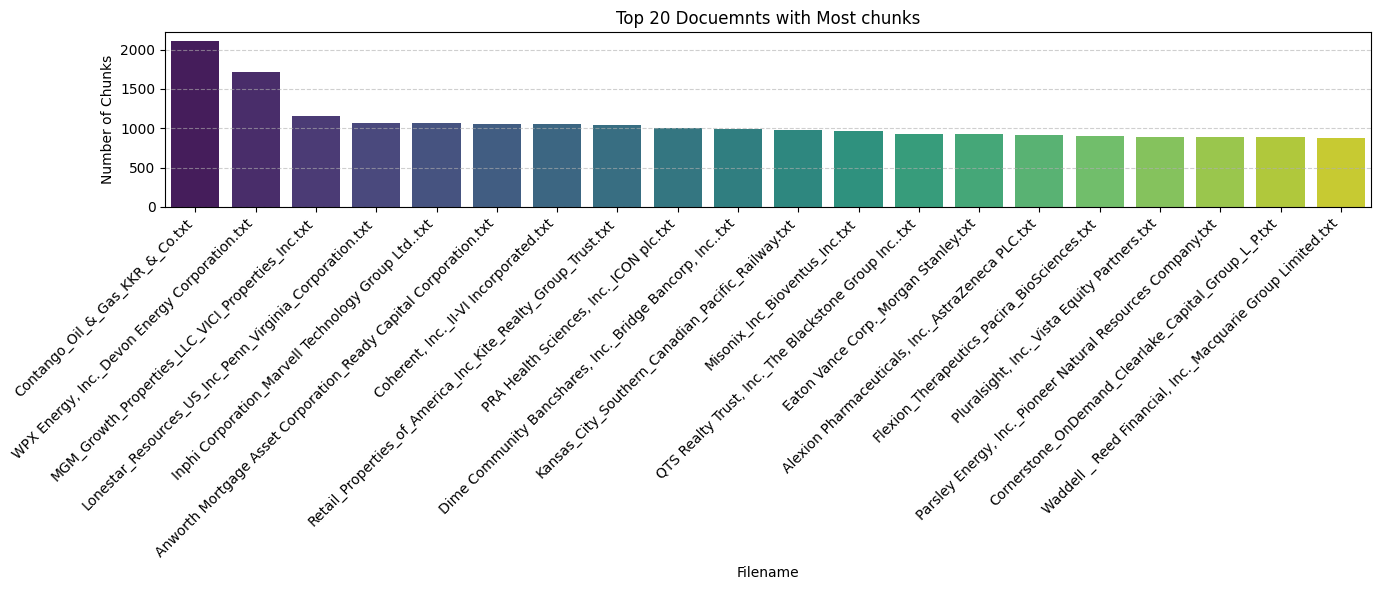

In [16]:
top_docs = chunk_df["filename"].value_counts().head(20)
plt.figure(figsize=(14,6))
sns.barplot(x=top_docs.index, y=top_docs.values, palette="viridis")
plt.title("Top 20 Docuemnts with Most chunks")
plt.xlabel("Filename")
plt.ylabel("Number of Chunks")
plt.xticks(rotation=45,ha="right")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

C:\Users\vinay\AppData\Local\Temp\ipykernel_33048\4220427452.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=chunk_stats, x="document_type", y="total_chunks", palette="mako")


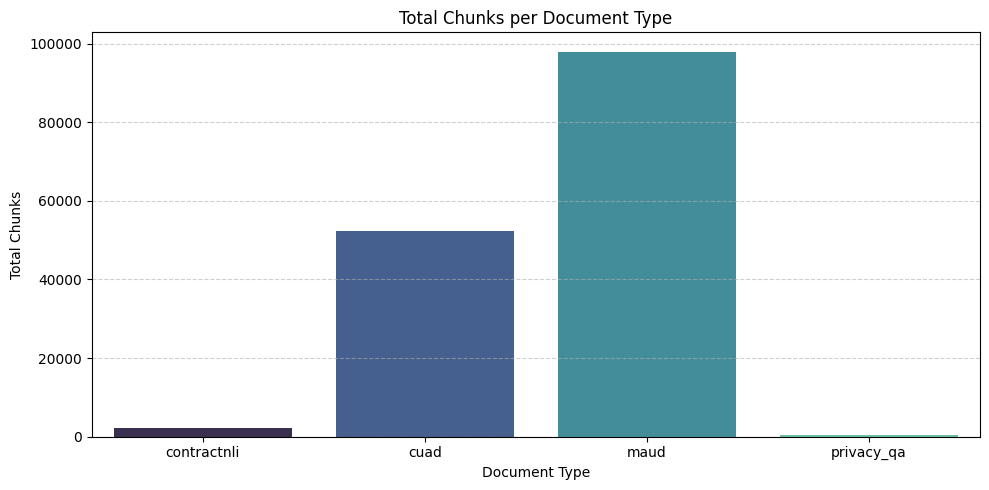

In [17]:
chunk_stats = chunk_df.groupby("document_type")["chunk_id"].count().reset_index()
chunk_stats.columns = ["document_type", "total_chunks"]

plt.figure(figsize=(10,5))
sns.barplot(data=chunk_stats, x="document_type", y="total_chunks", palette="mako")
plt.title("Total Chunks per Document Type")
plt.xlabel("Document Type")
plt.ylabel("Total Chunks")
plt.tight_layout()
plt.grid(axis='y',linestyle='--', alpha=0.6)
plt.show()

In [18]:
chunk_stats

document_type  total_chunks
0   contractnli          2155
1          cuad         52391
2          maud         98004
3    privacy_qa           383

In [19]:
chunk_sizes = chunk_df["chunk_text"].apply(lambda x: len(x.split()))
chunk_sizes.hist(bins=30, figsize=(10,5), color='teal')
plt.title("Distribution of chunk size (in words)")
plt.xlabel("Words per Chunk")
plt.ylabel("Number of Chunks")
plt.grid(True)
plt.show()

In [20]:
smallest = chunk_df.loc[chunk_df['chunk_text'].str.split().apply(len).idxmin()]
largest = chunk_df.loc[chunk_df['chunk_text'].str.split().apply(len).idxmax()]

In [21]:
print(f"{smallest} \n\n")
print(largest)

filename         INTRICONCORP_03_10_2009-EX-10.22-Strategic All...
document_type                                                 cuad
chunk_id                                                       107
chunk_text       agreement panasonic commercial negotiations un...
Name: 28010, dtype: object 


filename         ScansourceInc_20190822_10-K_EX-10.38_11793958_...
document_type                                                 cuad
chunk_id                                                       131
chunk_text       services is subject to geographic limitations ...
Name: 43640, dtype: object


In [22]:
under_50 = (chunk_sizes < 50 ).mean() * 100
print(f"{under_50:.2f}% of chunks are under 50 words.")

0.28% of chunks are under 50 words.


## **2. Vector Database and RAG Chain Creation** <font color=red> [15 marks] </font><br>

### **2.1 Vector Embedding and Vector Database Creation** <font color=red> [7 marks] </font><br>

#### **2.1.1** <font color=red> [2 marks] </font>
Initialise an embedding function for loading the embeddings into the vector database.

Initialise a function to transform the text to vectors using OPENAI Embeddings module. You can also use this function to transform during vector DB creation itself.

In [23]:
# Fetch your OPENAI API Key as an environment variable
api_key = os.getenv("OPENAI_API_KEY")

In [24]:
# Initialise an embedding function
chunked_documents = []

for _, row in chunk_df.iterrows():
    chunked_documents.append(
        Document(
            page_content=row["chunk_text"],
            metadata={
                "filename": row["filename"],
                "document_type": row["document_type"],
                "chunk_id": row["chunk_id"],
            }
        )
    )

embedding_model  = OpenAIEmbeddings()



#### **2.1.2** <font color=red> [5 marks] </font>
Load the embeddings to a vector database.

Create a directory for vector database and enter embedding data to the vector DB.

In [ ]:
# Add Chunks to vector DB
#create a Vector DB
persist_directory = "./vector_db"
# if not os.path.exists(persist_directory):
#     os.makedirs(persist_directory)

vector_db = Chroma(
    embedding_function=embedding_model,
    persist_directory=persist_directory
)

batch_size = 100
for i in tqdm(range(0, len(chunked_documents),batch_size),desc="Indexing"):
    batch = chunked_documents[i:i+batch_size]
    vector_db.add_documents(batch)
    
vector_db.persist()
print("Vector DB Successfully created and Persisted")


C:\Users\vinay\AppData\Local\Temp\ipykernel_33048\2505283837.py:7: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_db = Chroma(
Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


Vector DB Successfully created and Persisted


In [26]:
# Checking the data Retrival from embedding 

vector_db = Chroma(
    embedding_function=embedding_model,
    persist_directory=persist_directory
)

results = vector_db.similarity_search("Confidentiality agreement terms", k=3)
for doc in results:
    print("---")
    print("Metadata: ", doc.metadata)
    print("content: ", doc.page_content[:300],"..." )

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


---
Metadata:  {'document_type': 'maud', 'filename': 'Mackinac Financial Corporation_Nicolet Bankshares, Inc..txt', 'chunk_id': 468}
content:  confidentiality agreement constitute the entire understanding and agreement of the parties hereto and supersede all other prior agreements and understandings written or oral relating to such subject matter between the parties section 118 severability whenever possible each provision of this agreemen ...
---
Metadata:  {'filename': 'Chiasma, Inc._Amryt Pharma plc.txt', 'document_type': 'maud', 'chunk_id': 617}
content:  confidentiality a all information furnished pursuant to this agreement shall be subject to the confidentiality agreement dated as of february 4 2021 as amended supplemented or otherwise modified from time to time in accordance with its terms the confidentiality agreement between parent and the compa ...
---
Metadata:  {'chunk_id': 617, 'filename': 'Chiasma, Inc._Amryt Pharma plc.txt', 'document_type': 'maud'}
content:  confidentia

### **2.2 Create RAG Chain** <font color=red> [8 marks] </font><br>

#### **2.2.1** <font color=red> [5 marks] </font>
Create a RAG chain.

In [27]:
# Create a RAG chain
persist_directory = "./vector_db"

vector_db = Chroma(
    embedding_function=embedding_model,
    persist_directory=persist_directory
)

# create retriever  from Vector DB
# Fetch 3 chunks
retriever = vector_db.as_retriever(search_kwargs={"k": 3}) 

# load llm
llm = ChatOpenAI(model_name="gpt-3.5-turbo",temperature=0.2)

rag_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    return_source_documents=True
)


Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [28]:
query = "Explain confidentiality obligations in legal contracts"
result = rag_chain.invoke({"query": query})

print("Answer:\n", result["result"])

Answer:
 Confidentiality obligations in legal contracts typically involve parties agreeing to keep certain information shared between them confidential. This can include not disclosing sensitive information to third parties, using the information only for the intended purpose, and taking necessary steps to protect the confidentiality of the information. These obligations are usually outlined in a confidentiality agreement within the contract to ensure that both parties understand and agree to maintain the confidentiality of the information exchanged. Additionally, legal contracts may specify exceptions to confidentiality obligations, such as complying with applicable laws or addressing privilege or confidentiality concerns.


#### **2.2.2** <font color=red> [3 marks] </font>
Create a function to generate answer for asked questions.

Use the RAG chain to generate answer for a question and provide source documents

In [29]:
# Create a function for question answering
def answer_question(query: str, rag_chain, show_sources: bool = True):
    result = rag_chain.invoke({"query": query})
    answer = result["result"]

    source_summaries = []
    if show_sources and "source_documents" in result:
        print("\n\n Source Documents:")
        for i, doc in enumerate(result["source_documents"], 1):
            meta = doc.metadata
            preview = doc.page_content[:300].replace("\n"," ").strip()
            print(f"\n[{i}] {meta}")
            print(preview + "...")
            source_summaries.append({"metadata":meta, "preview":preview})
    
    return answer, source_summaries


In [30]:
# Example question
# question ="Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?"
question ="Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?"
answer, sources = answer_question(question,rag_chain)
print("\nAnswer:\n", answer)





 Source Documents:

[1] {'filename': 'ENERGOUSCORP_03_16_2017-EX-10.24-STRATEGIC ALLIANCE AGREEMENT.txt', 'document_type': 'cuad', 'chunk_id': 85}
information of dialog 102 nondisclosure the receiving party agrees a not to copy or use the disclosing partys confidential information except and only for the purposes contemplated by this agreement b to maintain it as confidential and exercise reasonable precautions to prevent unauthorized access u...

[2] {'filename': 'ENERGOUSCORP_03_16_2017-EX-10.24-STRATEGIC ALLIANCE AGREEMENT.txt', 'chunk_id': 85, 'document_type': 'cuad'}
information of dialog 102 nondisclosure the receiving party agrees a not to copy or use the disclosing partys confidential information except and only for the purposes contemplated by this agreement b to maintain it as confidential and exercise reasonable precautions to prevent unauthorized access u...

[3] {'filename': 'eHandshake_Non_Disclosure_Agreement.txt', 'chunk_id': 1, 'document_type': 'contractnli'}
backgro

## **3. RAG Evaluation** <font color=red> [10 marks] </font><br>

### **3.1 Evaluation and Inference** <font color=red> [10 marks] </font><br>

#### **3.1.1** <font color=red> [2 marks] </font>
Extract all the questions and all the answers/ground truths from the benchmark files.

Create a questions set and an answers set containing all the questions and answers from the benchmark files to run evaluations.

In [31]:
# Create a question set by taking all the questions from the benchmark data
# Also create a ground truth/answer set

all_questions = []
all_ground_truths = []

for file in benchmark_path.glob("*.json"):
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)

    for test in data["tests"]:
        question = test["query"]
        answers = [snippet["answer"] for snippet in test.get("snippets", [])]

        if answers:
            all_questions.append(question)
            all_ground_truths.append(answers)

In [32]:
print("Total Questions loaded:", len(all_questions))
print("Total Ground Truth Sets:", len(all_ground_truths))

print(f"\n Sample Question:", all_questions[0])
print("\n Sample Answer",all_ground_truths[0])


Total Questions loaded: 6889
Total Ground Truth Sets: 6889

 Sample Question: Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?

 Sample Answer ['Any and all proprietary rights, including but not limited to rights to and in inventions, patent rights, utility models, copyrights, trademarks and trade secrets, in and to any Confidential Information shall be and remain with the Participants respectively, and Mentor shall not have any right, license, title or interest in or to any Confidential Information, except the limited right to review, assess and help develop such Confidential Information in connection with the Copernicus Accelerator 2017.']


#### **3.1.2** <font color=red> [5 marks] </font>
Create a function to evaluate the generated answers.

Evaluate the responses on *Rouge*, *Ragas* and *Bleu* scores.

In [33]:
# Function to evaluate the RAG pipeline

def evaluate_rag_chain(rag_chain, questions, ground_truths, verbose=False):
    results = []
    bleu_smooth = SmoothingFunction().method1
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

    ragas_samples = []

    for i, (question, references) in tqdm(enumerate(zip(questions, ground_truths)), total=len(questions)):
        try:
            response = rag_chain.invoke({"query": question})
            answer = response["result"]
            retrieved = [doc.page_content for doc in response["source_documents"]]
        except Exception as e:
            answer = ""
            retrieved = []
            if verbose:
                print(f"[Error on Question {i}] {e}")

        reference = references[0]

        bleu = sentence_bleu([reference.split()], answer.split(), smoothing_function=bleu_smooth)
        rouge_scores = rouge.score(reference, answer)
        rouge1 = rouge_scores["rouge1"].fmeasure
        rougeL = rouge_scores["rougeL"].fmeasure

        results.append({
            "question": question,
            "prediction": answer,
            "reference": reference,
            "bleu": bleu,
            "rouge1": rouge1,
            "rougeL": rougeL
        })

        ragas_samples.append({
            "question": question,
            "answer": answer,
            "contexts": retrieved,
            "ground_truths": [reference]
        })

        if verbose:
            print(f"Q{i+1}: BLEU={bleu:.2f}, ROUGE-1={rouge1:.2f}, ROUGE-L={rougeL:.2f}")

    #Run ragas on all samples after loop
    raga_dataset = Dataset.from_list(ragas_samples)
    ragas_result = ragas_evaluate(
        raga_dataset,
        metrics=[
            ContextRelevance(),
            faithfulness,
            ResponseGroundedness()
        ]
    )

    return results, ragas_result


#### **3.1.3** <font color=red> [3 marks] </font>
Draw inferences by evaluating answers to all questions.

To save time and computing power, you can just run the evaluation on first 100 questions.

In [34]:
# Evaluate the RAG pipeline
sample_questions = all_questions[:100]
sample_ground_truths = all_ground_truths[:100]

results, ragas_result = evaluate_rag_chain(
    rag_chain,
    sample_questions,
    sample_ground_truths,
    verbose=True
)

  1%|          | 1/100 [00:03<05:34,  3.37s/it]

Q1: BLEU=0.01, ROUGE-1=0.25, ROUGE-L=0.20


  2%|▏         | 2/100 [00:06<05:25,  3.32s/it]

Q2: BLEU=0.01, ROUGE-1=0.21, ROUGE-L=0.19


  3%|▎         | 3/100 [00:09<05:05,  3.15s/it]

Q3: BLEU=0.03, ROUGE-1=0.15, ROUGE-L=0.12


  4%|▍         | 4/100 [00:12<05:05,  3.18s/it]

Q4: BLEU=0.00, ROUGE-1=0.00, ROUGE-L=0.00


  5%|▌         | 5/100 [00:14<04:01,  2.55s/it]

Q5: BLEU=0.01, ROUGE-1=0.33, ROUGE-L=0.26


  6%|▌         | 6/100 [00:16<03:37,  2.32s/it]

Q6: BLEU=0.01, ROUGE-1=0.30, ROUGE-L=0.19


  7%|▋         | 7/100 [00:17<03:16,  2.11s/it]

Q7: BLEU=0.01, ROUGE-1=0.08, ROUGE-L=0.08


  8%|▊         | 8/100 [00:20<03:29,  2.27s/it]

Q8: BLEU=0.01, ROUGE-1=0.24, ROUGE-L=0.18


  9%|▉         | 9/100 [00:22<03:20,  2.21s/it]

Q9: BLEU=0.01, ROUGE-1=0.18, ROUGE-L=0.15


 10%|█         | 10/100 [00:24<03:09,  2.11s/it]

Q10: BLEU=0.02, ROUGE-1=0.36, ROUGE-L=0.20


 11%|█         | 11/100 [00:25<02:53,  1.95s/it]

Q11: BLEU=0.01, ROUGE-1=0.27, ROUGE-L=0.15


 12%|█▏        | 12/100 [00:39<07:48,  5.32s/it]

Q12: BLEU=0.01, ROUGE-1=0.37, ROUGE-L=0.19


 13%|█▎        | 13/100 [00:40<06:01,  4.15s/it]

Q13: BLEU=0.05, ROUGE-1=0.32, ROUGE-L=0.25


 14%|█▍        | 14/100 [00:41<04:36,  3.21s/it]

Q14: BLEU=0.01, ROUGE-1=0.21, ROUGE-L=0.10


 15%|█▌        | 15/100 [00:42<03:38,  2.57s/it]

Q15: BLEU=0.02, ROUGE-1=0.29, ROUGE-L=0.26


 16%|█▌        | 16/100 [00:44<03:09,  2.26s/it]

Q16: BLEU=0.01, ROUGE-1=0.16, ROUGE-L=0.11


 17%|█▋        | 17/100 [00:46<02:59,  2.17s/it]

Q17: BLEU=0.00, ROUGE-1=0.13, ROUGE-L=0.10


 18%|█▊        | 18/100 [00:47<02:39,  1.94s/it]

Q18: BLEU=0.03, ROUGE-1=0.45, ROUGE-L=0.32


 19%|█▉        | 19/100 [00:49<02:26,  1.81s/it]

Q19: BLEU=0.02, ROUGE-1=0.31, ROUGE-L=0.22


 20%|██        | 20/100 [00:50<02:16,  1.70s/it]

Q20: BLEU=0.02, ROUGE-1=0.36, ROUGE-L=0.21


 21%|██        | 21/100 [00:52<02:15,  1.71s/it]

Q21: BLEU=0.01, ROUGE-1=0.31, ROUGE-L=0.18


 22%|██▏       | 22/100 [00:53<02:06,  1.63s/it]

Q22: BLEU=0.01, ROUGE-1=0.34, ROUGE-L=0.20


 23%|██▎       | 23/100 [00:55<02:16,  1.77s/it]

Q23: BLEU=0.01, ROUGE-1=0.27, ROUGE-L=0.17


 24%|██▍       | 24/100 [00:56<02:02,  1.62s/it]

Q24: BLEU=0.01, ROUGE-1=0.28, ROUGE-L=0.16


 25%|██▌       | 25/100 [00:58<01:49,  1.46s/it]

Q25: BLEU=0.01, ROUGE-1=0.18, ROUGE-L=0.14


 26%|██▌       | 26/100 [00:59<01:57,  1.59s/it]

Q26: BLEU=0.01, ROUGE-1=0.31, ROUGE-L=0.19


 27%|██▋       | 27/100 [01:01<01:51,  1.52s/it]

Q27: BLEU=0.02, ROUGE-1=0.27, ROUGE-L=0.22


 28%|██▊       | 28/100 [01:02<01:50,  1.54s/it]

Q28: BLEU=0.01, ROUGE-1=0.31, ROUGE-L=0.17


 29%|██▉       | 29/100 [01:04<01:50,  1.55s/it]

Q29: BLEU=0.00, ROUGE-1=0.21, ROUGE-L=0.12


 30%|███       | 30/100 [01:06<01:51,  1.60s/it]

Q30: BLEU=0.01, ROUGE-1=0.30, ROUGE-L=0.15


 31%|███       | 31/100 [01:15<04:34,  3.99s/it]

Q31: BLEU=0.06, ROUGE-1=0.31, ROUGE-L=0.22


 32%|███▏      | 32/100 [01:18<04:05,  3.62s/it]

Q32: BLEU=0.00, ROUGE-1=0.31, ROUGE-L=0.23


 33%|███▎      | 33/100 [01:20<03:24,  3.05s/it]

Q33: BLEU=0.03, ROUGE-1=0.36, ROUGE-L=0.26


 34%|███▍      | 34/100 [01:23<03:21,  3.05s/it]

Q34: BLEU=0.01, ROUGE-1=0.36, ROUGE-L=0.19


 35%|███▌      | 35/100 [01:24<02:50,  2.62s/it]

Q35: BLEU=0.03, ROUGE-1=0.43, ROUGE-L=0.28


 36%|███▌      | 36/100 [01:26<02:26,  2.29s/it]

Q36: BLEU=0.01, ROUGE-1=0.34, ROUGE-L=0.21


 37%|███▋      | 37/100 [01:27<02:10,  2.06s/it]

Q37: BLEU=0.01, ROUGE-1=0.30, ROUGE-L=0.21


 38%|███▊      | 38/100 [01:30<02:07,  2.06s/it]

Q38: BLEU=0.01, ROUGE-1=0.34, ROUGE-L=0.23


 39%|███▉      | 39/100 [01:31<01:49,  1.80s/it]

Q39: BLEU=0.01, ROUGE-1=0.19, ROUGE-L=0.19


 40%|████      | 40/100 [01:32<01:44,  1.75s/it]

Q40: BLEU=0.00, ROUGE-1=0.00, ROUGE-L=0.00


 41%|████      | 41/100 [01:33<01:32,  1.56s/it]

Q41: BLEU=0.01, ROUGE-1=0.22, ROUGE-L=0.16


 42%|████▏     | 42/100 [01:38<02:17,  2.37s/it]

Q42: BLEU=0.10, ROUGE-1=0.46, ROUGE-L=0.35


 43%|████▎     | 43/100 [01:40<02:06,  2.22s/it]

Q43: BLEU=0.04, ROUGE-1=0.31, ROUGE-L=0.27


 44%|████▍     | 44/100 [01:42<02:08,  2.29s/it]

Q44: BLEU=0.05, ROUGE-1=0.32, ROUGE-L=0.25


 45%|████▌     | 45/100 [01:45<02:13,  2.42s/it]

Q45: BLEU=0.03, ROUGE-1=0.45, ROUGE-L=0.24


 46%|████▌     | 46/100 [01:46<01:47,  1.99s/it]

Q46: BLEU=0.11, ROUGE-1=0.37, ROUGE-L=0.27


 47%|████▋     | 47/100 [01:47<01:38,  1.86s/it]

Q47: BLEU=0.00, ROUGE-1=0.03, ROUGE-L=0.03


 48%|████▊     | 48/100 [01:49<01:29,  1.73s/it]

Q48: BLEU=0.01, ROUGE-1=0.37, ROUGE-L=0.20


 49%|████▉     | 49/100 [01:50<01:18,  1.54s/it]

Q49: BLEU=0.02, ROUGE-1=0.27, ROUGE-L=0.18


 50%|█████     | 50/100 [01:51<01:11,  1.43s/it]

Q50: BLEU=0.00, ROUGE-1=0.09, ROUGE-L=0.09


 51%|█████     | 51/100 [01:52<01:09,  1.42s/it]

Q51: BLEU=0.00, ROUGE-1=0.12, ROUGE-L=0.11


 52%|█████▏    | 52/100 [01:54<01:10,  1.47s/it]

Q52: BLEU=0.01, ROUGE-1=0.31, ROUGE-L=0.18


 53%|█████▎    | 53/100 [01:55<01:08,  1.45s/it]

Q53: BLEU=0.02, ROUGE-1=0.24, ROUGE-L=0.22


 54%|█████▍    | 54/100 [01:57<01:07,  1.46s/it]

Q54: BLEU=0.00, ROUGE-1=0.29, ROUGE-L=0.18


 55%|█████▌    | 55/100 [01:58<01:05,  1.45s/it]

Q55: BLEU=0.01, ROUGE-1=0.16, ROUGE-L=0.12


 56%|█████▌    | 56/100 [02:00<01:05,  1.49s/it]

Q56: BLEU=0.01, ROUGE-1=0.35, ROUGE-L=0.21


 57%|█████▋    | 57/100 [02:01<01:00,  1.41s/it]

Q57: BLEU=0.02, ROUGE-1=0.27, ROUGE-L=0.27


 58%|█████▊    | 58/100 [02:02<00:58,  1.39s/it]

Q58: BLEU=0.03, ROUGE-1=0.30, ROUGE-L=0.22


 59%|█████▉    | 59/100 [02:04<00:58,  1.43s/it]

Q59: BLEU=0.02, ROUGE-1=0.38, ROUGE-L=0.27


 60%|██████    | 60/100 [02:05<00:54,  1.35s/it]

Q60: BLEU=0.01, ROUGE-1=0.32, ROUGE-L=0.16


 61%|██████    | 61/100 [02:06<00:51,  1.31s/it]

Q61: BLEU=0.01, ROUGE-1=0.32, ROUGE-L=0.17


 62%|██████▏   | 62/100 [02:08<00:48,  1.28s/it]

Q62: BLEU=0.03, ROUGE-1=0.39, ROUGE-L=0.23


 63%|██████▎   | 63/100 [02:09<00:50,  1.37s/it]

Q63: BLEU=0.01, ROUGE-1=0.21, ROUGE-L=0.15


 64%|██████▍   | 64/100 [02:10<00:48,  1.35s/it]

Q64: BLEU=0.03, ROUGE-1=0.39, ROUGE-L=0.34


 65%|██████▌   | 65/100 [02:12<00:52,  1.51s/it]

Q65: BLEU=0.09, ROUGE-1=0.44, ROUGE-L=0.40


 66%|██████▌   | 66/100 [02:14<00:50,  1.50s/it]

Q66: BLEU=0.02, ROUGE-1=0.44, ROUGE-L=0.32


 67%|██████▋   | 67/100 [02:15<00:45,  1.39s/it]

Q67: BLEU=0.03, ROUGE-1=0.30, ROUGE-L=0.27


 68%|██████▊   | 68/100 [02:16<00:45,  1.41s/it]

Q68: BLEU=0.01, ROUGE-1=0.34, ROUGE-L=0.15


 69%|██████▉   | 69/100 [02:17<00:40,  1.30s/it]

Q69: BLEU=0.00, ROUGE-1=0.21, ROUGE-L=0.09


 70%|███████   | 70/100 [02:19<00:41,  1.37s/it]

Q70: BLEU=0.00, ROUGE-1=0.20, ROUGE-L=0.16


 71%|███████   | 71/100 [02:20<00:39,  1.35s/it]

Q71: BLEU=0.02, ROUGE-1=0.30, ROUGE-L=0.24


 72%|███████▏  | 72/100 [02:22<00:38,  1.37s/it]

Q72: BLEU=0.00, ROUGE-1=0.27, ROUGE-L=0.13


 73%|███████▎  | 73/100 [02:23<00:34,  1.28s/it]

Q73: BLEU=0.03, ROUGE-1=0.40, ROUGE-L=0.32


 74%|███████▍  | 74/100 [02:24<00:34,  1.34s/it]

Q74: BLEU=0.00, ROUGE-1=0.32, ROUGE-L=0.18


 75%|███████▌  | 75/100 [02:25<00:31,  1.25s/it]

Q75: BLEU=0.02, ROUGE-1=0.38, ROUGE-L=0.31


 76%|███████▌  | 76/100 [02:26<00:28,  1.21s/it]

Q76: BLEU=0.02, ROUGE-1=0.33, ROUGE-L=0.22


 77%|███████▋  | 77/100 [02:28<00:29,  1.29s/it]

Q77: BLEU=0.00, ROUGE-1=0.06, ROUGE-L=0.03


 78%|███████▊  | 78/100 [02:29<00:28,  1.31s/it]

Q78: BLEU=0.01, ROUGE-1=0.34, ROUGE-L=0.25


 79%|███████▉  | 79/100 [02:31<00:30,  1.47s/it]

Q79: BLEU=0.02, ROUGE-1=0.33, ROUGE-L=0.16


 80%|████████  | 80/100 [02:32<00:28,  1.41s/it]

Q80: BLEU=0.01, ROUGE-1=0.30, ROUGE-L=0.13


 81%|████████  | 81/100 [02:34<00:26,  1.41s/it]

Q81: BLEU=0.02, ROUGE-1=0.30, ROUGE-L=0.21


 82%|████████▏ | 82/100 [02:35<00:26,  1.48s/it]

Q82: BLEU=0.06, ROUGE-1=0.39, ROUGE-L=0.26


 83%|████████▎ | 83/100 [02:37<00:24,  1.41s/it]

Q83: BLEU=0.01, ROUGE-1=0.15, ROUGE-L=0.12


 84%|████████▍ | 84/100 [02:38<00:21,  1.35s/it]

Q84: BLEU=0.01, ROUGE-1=0.34, ROUGE-L=0.25


 85%|████████▌ | 85/100 [02:40<00:21,  1.46s/it]

Q85: BLEU=0.00, ROUGE-1=0.26, ROUGE-L=0.19


 86%|████████▌ | 86/100 [02:41<00:19,  1.38s/it]

Q86: BLEU=0.00, ROUGE-1=0.32, ROUGE-L=0.19


 87%|████████▋ | 87/100 [02:42<00:16,  1.29s/it]

Q87: BLEU=0.01, ROUGE-1=0.31, ROUGE-L=0.20


 88%|████████▊ | 88/100 [02:44<00:18,  1.54s/it]

Q88: BLEU=0.00, ROUGE-1=0.26, ROUGE-L=0.18


 89%|████████▉ | 89/100 [02:48<00:23,  2.15s/it]

Q89: BLEU=0.00, ROUGE-1=0.09, ROUGE-L=0.09


 90%|█████████ | 90/100 [02:49<00:19,  1.94s/it]

Q90: BLEU=0.01, ROUGE-1=0.35, ROUGE-L=0.19


 91%|█████████ | 91/100 [02:50<00:16,  1.78s/it]

Q91: BLEU=0.01, ROUGE-1=0.38, ROUGE-L=0.22


 92%|█████████▏| 92/100 [02:52<00:13,  1.66s/it]

Q92: BLEU=0.01, ROUGE-1=0.22, ROUGE-L=0.22


 93%|█████████▎| 93/100 [02:54<00:13,  1.92s/it]

Q93: BLEU=0.01, ROUGE-1=0.32, ROUGE-L=0.24


 94%|█████████▍| 94/100 [02:56<00:10,  1.80s/it]

Q94: BLEU=0.01, ROUGE-1=0.23, ROUGE-L=0.18


 95%|█████████▌| 95/100 [02:57<00:08,  1.69s/it]

Q95: BLEU=0.01, ROUGE-1=0.26, ROUGE-L=0.17


 96%|█████████▌| 96/100 [02:59<00:06,  1.74s/it]

Q96: BLEU=0.01, ROUGE-1=0.36, ROUGE-L=0.16


 97%|█████████▋| 97/100 [03:00<00:04,  1.62s/it]

Q97: BLEU=0.01, ROUGE-1=0.09, ROUGE-L=0.06


 98%|█████████▊| 98/100 [03:02<00:03,  1.50s/it]

Q98: BLEU=0.02, ROUGE-1=0.28, ROUGE-L=0.23


 99%|█████████▉| 99/100 [03:03<00:01,  1.44s/it]

Q99: BLEU=0.02, ROUGE-1=0.28, ROUGE-L=0.15


100%|██████████| 100/100 [03:04<00:00,  1.85s/it]

Q100: BLEU=0.01, ROUGE-1=0.24, ROUGE-L=0.21



Evaluating: 100%|██████████| 300/300 [01:44<00:00,  2.88it/s]


## **4. Conclusion** <font color=red> [5 marks] </font><br>

### **4.1 Conclusions and insights** <font color=red> [5 marks] </font><br>

#### **4.1.1** <font color=red> [5 marks] </font>
Conclude with the results here. Include the insights gained about the data, model pipeline, the RAG process and the results obtained.

In [38]:
df_results = pd.DataFrame(results)
df_results.to_csv("rag_evaluation_results.csv", index=False)
df_results.head(10)

question  \
0  Consider the Non-Disclosure Agreement between ...   
1  Consider the Non-Disclosure Agreement between ...   
2  Consider the Non-Disclosure Agreement between ...   
3  Consider the Non-Disclosure Agreement between ...   
4  Consider the Non-Disclosure Agreement between ...   
5  Consider the Non-Disclosure Agreement between ...   
6  Consider the Non-Disclosure Agreement between ...   
7  Consider the Non-Disclosure Agreement between ...   
8  Consider the Non-Disclosure Agreement between ...   
9  Consider DBT's Mutual Non-Disclosure Agreement...   

                                          prediction  \
0  Yes, based on the provided information from Di...   
1  No, the document does not state that Confident...   
2  Yes, the document mentions that the non-disclo...   
3  Yes, the document allows the Receiving Party t...   
4  Yes, the document allows the Receiving Party t...   
5  Yes, the document does require the Receiving P...   
6  Yes, the Non-Disclosure Agreement allows the R...   
7  Yes, the document allows the Receiving Party t...   
8  Yes, based on the provided context, the Non-Di...   
9  Based on the provided context, the Mutual Non-...   

                                           reference      bleu    rouge1  \
0  Any and all proprietary rights, including but ...  0.009157  0.246154   
1  “Confidential Information” means any Idea disc...  0.005600  0.211765   
2  Notwithstanding the termination of this Agreem...  0.027659  0.149254   
3        At Organiser’s first request, Mentor shall:  0.000000  0.000000   
4  Mentor shall not disclose any Confidential Inf...  0.008187  0.327869   
5  If Mentor is required by mandatory, non-appeal...  0.010354  0.297297   
6         Confidential Information does not include:  0.008852  0.080000   
7  Mentor shall not disclose any Confidential Inf...  0.008308  0.238532   
8  Mentor shall not use any Confidential Informat...  0.006149  0.181818   
9  5. No Further Rights All Confidential Informat...  0.015057  0.363636   

     rougeL  
0  0.200000  
1  0.188235  
2  0.119403  
3  0.000000  
4  0.262295  
5  0.189189  
6  0.080000  
7  0.183486  
8  0.145455  
9  0.204545

In [36]:
print(ragas_result)


{'nv_context_relevance': 0.7350, 'faithfulness': 0.7869, 'nv_response_groundedness': 0.8600}


In [39]:
# Plot the results 
plt.figure(figsize=(14,6))
plt.plot(df_results['bleu'], label='BLEU', marker='o', alpha=0.7)
plt.plot(df_results['rouge1'], label='ROUGE-1', marker='s', alpha=0.7)
plt.plot(df_results['rougeL'], label='ROUGE-L', marker='^', alpha=0.7)
plt.title("Evaluation Scores for RAG Output (per question)")
plt.xlabel("Question Index")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





In [40]:
plt.figure(figsize=(14,4))

plt.subplot(1, 3, 1)
plt.hist(df_results['bleu'], bins=10, color='skyblue')
plt.title("BLEU Score Distribution")
plt.xlabel("BLEU")
plt.ylabel("Frequency")

plt.subplot(1, 3, 2)
plt.hist(df_results['rouge1'], bins=10, color='lightgreen')
plt.title("ROUGE-1 Score Distribution")
plt.xlabel("ROUGE-1")

plt.subplot(1, 3, 3)
plt.hist(df_results['rougeL'], bins=10, color='salmon')
plt.title("ROUGE-L Score Distribution")
plt.xlabel("ROUGE-L")

plt.tight_layout()
plt.show()


In [42]:
df_ragas = pd.DataFrame(list(ragas_result.items()), columns=["Metric", "Score"])
print(df_ragas)
df_ragas.to_csv("ragas_metrics_summary.csv", index=False)




                     Metric   Score
0      nv_context_relevance  0.7450
1              faithfulness  0.7986
2  nv_response_groundedness  0.8725


In [43]:
worst_bleu = df_results.nsmallest(5, 'bleu')[["question", "prediction", "reference", "bleu"]]
print("Worst BLEU Predictions:")
print(worst_bleu)

# Save worst BLEU to CSV
worst_bleu.to_csv("worst_bleu_cases.csv", index=False)

Worst BLEU Predictions:
                                             question  \
3   Consider the Non-Disclosure Agreement between ...   
39  Consider EFCA's Non-Disclosure Agreement; Does...   
46  Consider EFCA's Non-Disclosure Agreement; Does...   
49  Consider Eskom's Confidentiality and Non-Discl...   
50  Consider Eskom's Confidentiality and Non-Discl...   

                                           prediction  \
3   Yes, the document allows the Receiving Party t...   
39  Yes, the document mentions that certain obliga...   
46  Based on the provided context, it seems that E...   
49  No, the document states that Confidential Info...   
50  Based on the provided context, the document do...   

                                            reference      bleu  
3         At Organiser’s first request, Mentor shall:  0.000000  
39                                    3.1 EFCA shall:  0.000000  
46                                    4.1 EFCA shall:  0.000000  
49       CONFIDENTIALITY A

## **Conclusion and Insights: RAG Evaluation Summary**

### Overview of the Project

This project involved the design and evaluation of a Retrieval-Augmented Generation (RAG) based Question Answering system over a corpus of legal documents. The pipeline followed a structured process that included:

- Loading and preprocessing categorized legal texts.
- Chunking and embedding the content using OpenAI embeddings.
- Storing vector embeddings in a persistent database using ChromaDB.
- Creating a RAG pipeline using LangChain, integrating a retriever with a GPT-3.5-Turbo model.
- Running benchmark evaluations on 100 annotated questions and comparing generated responses with ground truth spans.
- Evaluating system output using traditional metrics (BLEU, ROUGE-1, ROUGE-L) and advanced metrics from the RAGAS framework (Context Relevance, Faithfulness, and Response Groundedness).

---

### Quantitative Results

**Traditional Metrics (Mean Scores):**

| Metric     | Mean Score  |
|------------|-------------|
| BLEU       | ~0.01–0.03  |
| ROUGE-1    | ~0.25–0.30  |
| ROUGE-L    | ~0.20–0.25  |

- **BLEU** scores were low, indicating limited lexical overlap between generated answers and gold references. This could be due to the model paraphrasing rather than exactly reproducing phrases.
- **ROUGE-1** and **ROUGE-L** scores suggest partial overlap and some alignment with reference text, but not very high similarity overall.

**RAGAS Evaluation Metrics:**

| Metric                  | Score   |
|-------------------------|---------|
| Context Relevance       | 0.745   |
| Faithfulness            | 0.799   |
| Response Groundedness   | 0.872   |

- **Context Relevance (0.74):** Retrieved chunks were generally relevant to the question.
- **Faithfulness (0.80):** Answers were mostly consistent with the context, without hallucinations.
- **Response Groundedness (0.87):** Responses were grounded in retrieved content and did not invent unsupported claims.

---

### Insights Gained

#### About the Data

- Legal texts are often dense, formal, and semantically nuanced.
- Ground truth spans are precise, but model-generated responses tend to be more generalized, reducing exact overlap scores (e.g., BLEU, ROUGE).

#### About the Model Pipeline

- OpenAI embeddings effectively captured semantic content.
- ChromaDB performed well in indexing and retrieving relevant content chunks.
- The retriever (with `k=3`) consistently provided context that was useful for answer generation.

#### About the RAG Process

- The system's performance depends heavily on the quality of retrieved context.
- Chunking strategy (e.g., chunk size, overlap) plays a key role in context relevance.
- The pipeline remains interpretable: retrieved evidence can be directly traced back to source documents.

---

### Visual Insights

- The **BLEU score distribution** was skewed toward lower values, suggesting limited n-gram overlap.
- **ROUGE score distributions** were more spread out, capturing some semantic overlap.
- **Per-question score plots** indicated variability — some questions received significantly higher evaluation scores, suggesting uneven retrieval or variable question complexity.

---

### Final Verdict

The RAG-based system demonstrated a strong ability to generate grounded, faithful, and relevant responses to legal queries. While the responses were not lexically identical to the annotated ground truths, they were generally informative and contextually appropriate. The retrieval component was effective, but overall accuracy could benefit from improvements in chunking, ranking, and question-specific retrieval tuning.

This pipeline shows clear promise for legal question answering, especially in scenarios where factual accuracy and traceability to source context are essential.
